# <a id='toc1_'></a>[Hierarchical Bayesian Models with Dynamical Systems](#toc0_)

**Table of contents**<a id='toc0_'></a>     
- [Setup](#toc1_1_)    
- [Overview: Composing Hierarchical Bayesian Models with ODEs](#toc1_2_)    
  - [Background: causal reasoning in dynamical systems](#toc1_2_1_)    
  - [Modelling assumptions:](#toc1_2_2_)    
- [Causal probabilistic program](#toc1_3_)    
- [Multi-level Bayesian model](#toc1_4_)    
- [Using the model](#toc1_5_)    
  - [Probabilistic Inference over Dynamical System Parameters](#toc1_5_1_)    
  - [Inspecting the posterior marginals](#toc1_5_2_)    
  - [Inspecting the posterior predictive distribution](#toc1_5_3_)    
  - [Modeling Interventions](#toc1_5_4_)    
- [Looking Forward](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoMultivariateNormal


from chirho.dynamical.handlers import (
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_steps = 10 if smoke_test else 200
num_samples = 10 if smoke_test else 500

In [47]:
# plotting functions

line_styles = ["solid", "dashed", "dotted", "dashdot"]
colors = {"S": "blue", "I": "red", "R": "green"}


def SIR_uncertainty_plot(time_period, state_pred, color, ax, linestyle="solid", line_label=None):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0) if state_pred.ndim > 1 else state_pred,
        color=color,
        linestyle=linestyle,
        ax=ax,
        label=line_label,
    )

    if state_pred.ndim > 1:
        # 95% Credible Interval
        ax.fill_between(
            time_period,
            torch.quantile(state_pred, 0.025, dim=0),
            torch.quantile(state_pred, 0.975, dim=0),
            alpha=0.2,
            color=color,
            label="95% Credible Interval",
        )


def SIR_peak_plot(true_state, true_logging_times, ax, label=None):
    peak_idx = torch.argmax(true_state)
    ax.axvline(true_logging_times[peak_idx], color="red", label=label)


def SIR_data_plot(time_period, data, data_label, ax, color="black"):
    sns.scatterplot(x=time_period, y=data, color=color, ax=ax, label=data_label)


def SIR_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(test_end_time, color="black", linestyle=":")


def plot_sir_data(
    n_strata,
    colors,
    sir_traj=None,
    logging_times=None,
    sir_data=None,
    obs_logging_times=None,
    true_traj=None,
    true_logging_times=None,
    plot_true_peak=False,
    main_title=None,
):

    fig, ax = plt.subplots(n_strata, 3, figsize=(15, 5), sharex=True, sharey=True)

    if main_title is not None:
        fig.suptitle(main_title, fontsize=16)

    if sir_data is not None:
        SIR_data_plot(
            obs_logging_times,
            sir_data["I_obs"],
            color=colors["I"],
            ax=ax[0, 1],
            data_label="Observations",
        )

    if true_traj is not None:
        for i in range(n_strata):

            for j, key in enumerate(["S", "I", "R"]):
                SIR_uncertainty_plot(
                    true_logging_times,
                    true_traj[key][i, :],
                    color="black",
                    ax=ax[i, j],
                    linestyle="dashed",
                    line_label="True Trajectory" if i == 2 and j == 1 else None,
                )

            if plot_true_peak:
                SIR_peak_plot(true_traj["I"][i, :], true_logging_times, ax[i, 1], label="Peak Infection Time" if i == 1 else None)

    if sir_traj is not None:
        for i in range(n_strata):

            for j, key in enumerate(["S", "I", "R"]):
                SIR_uncertainty_plot(
                    logging_times,
                    sir_traj[key][..., 0, i, :],
                    color=colors[key],
                    ax=ax[i, j],
                )

    # Set x-axis labels
    ax[i, 0].set_xlabel("Time (months)")
    ax[i, 1].set_xlabel("Time (months)")
    ax[i, 2].set_xlabel("Time (months)")

    for i in range(n_strata):
        if i == 0:
            ax[i, 0].set_title("Susceptible")
            ax[i, 1].set_title("Infected")
            ax[i, 2].set_title("Recovered")

        ax_right_2 = ax[i, 2].twinx()
        ax_right_2.set_ylabel(f"Town {i+1}", rotation=270, labelpad=15)
        ax_right_2.yaxis.set_label_position("right")
        ax_right_2.tick_params(right=False)
        ax_right_2.set_yticklabels([])

    ax[0, 0].set_ylabel("")
    ax[2, 0].set_ylabel("")
    ax[1, 0].set_ylabel("Number of individuals (thousands)")

    ax[0, 1].legend(loc="upper right")
    ax[1, 1].legend(loc="upper right")
    ax[2, 1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()


## <a id='toc1_2_'></a>[Overview: Composing Hierarchical Bayesian Models with ODEs](#toc0_)

In our [previous tutorial on causal reasoning with continuous time dynamical systems](dynamical_intro.ipynb) we showed how tools like ChiRho can be extended to support declarative models that we don't typically think of as probabilistic programs, such as differential equations models. In particular, we showed how to 
- learn approximation posterior distributions over dynamical systems parameters using Pyro's support for variational inference and,
- predict the effect of (uncertain) policy decisions by extending ChiRho's intervention semantics to differential equations.

In this tutorial we expand on that simple example, demonstrating how richly structured probabilistic models compose seemlessly with dynamical systems models and solver technology. Specifically, we expand on that same epidemiological SIR model to include hierarchical priors over dynamical systems parameters for each of several distinct geographic locations. 

Just as we did in our introductory dynamical systems tutorial we'll follow a simple causal probabilsitic programming workflow in the rest of this notebook:
- First, we learn approximation posterior distributions over dynamical systems parameters using Pyro's support for variational inference, this time including over global latent variables across all strata.
- Second, we use the trained model to estimate the impact of a potential interventions in each strata. As we'll see later, our use of a hierarchical priors tightens our predictive uncertainty about the effects of interventions, even in stratum where we don't observe any data.

### Intuition ###

The key insight here is that the same Bayesian modeling motifs for pooling statistical information between distinct strata in standard Bayesian multilevel regression modeling (see Chapter 5 of Gelman et al.) can be used when the regression equations are swapped out with mechanistic models in the form of differential equations. Later in this tutorial we'll see how this simple modeling motif succinctly captures our intuition that information is shared across strata, and thus that data in one should inform our predictions in another.

### <a id='toc1_2_1_'></a>[Background: causal reasoning in dynamical systems](#toc0_)

If you haven't read the preliminary [tutorial on causal reasoning with continuous time dynamical systems](dynamical_intro.html), we strongly recommend doing so first beforing continuing. In that tutorial you'll find a short description of how we represent causal interventions in dynamical systems, as well as all of the details behind the SIR model used in this expanded tutorial.

### <a id='toc1_2_2_'></a>[Modeling assumptions:](#toc0_)

In this example, we again explore the SIR (Susceptible, Infected, Recovered) compartmental model, a fundamental model in epidemiology. Here, the variables of interest are:

- $S(t)$: the number of susceptible individuals at time $t$,

- $I(t)$: the number of infected individuals at time $t$, and

- $R(t)$: the number of recovered individuals at time $t$.

These compartments interact through a set of ordinary differential equations that describe the rate at which individuals move from being susceptible to infected, and from infected to recovered (see our [earlier tutorial](dynamical_intro.html) for details on the differential equations.). 

Unlike in the previous tutorial, where $S$, $I$, and $R$ are real-valued functions of time, in this tutorial these variables will be vector-valued functions of time, where each element corresponds to the number of people susceptible, infected, and recovered in a particular stratum. In this example, each stratum refers to an individual town. We will assume the interactions between compartments within each of the towns are guided by the same equations with potentially somewhat different parameters, coming from (respectively) the same common distributions. 

## <a id='toc1_3_'></a>[Causal probabilistic program](#toc0_)

Just as in the previous tutorial, we define the differential equation model as a `pyro.nn.PyroModule` as follows, where the forward method is a function from states `X` to the time derivatives of the states, `dX`. Fortunately, we can use the exact same implementation for the stratified example here, taking advantage of PyTorch's tensor broadcasting semantics.

In [30]:
class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]
        return dX


Also, we assume we only make observations in one of the locations. Conceptually, `single_observation_model()` takes a trajectory already produced by a simulation, and generates a sample of Poisson-distributed observations for the first stratum.

<!--  which - intuitively - should decrease our uncertaintly about that location more than about other locations, while still allowing us learn something about them, in virtue of the location-specific parameters coming from the same general distributions. -->

In [31]:
def sir_observation_model(X: State[torch.Tensor]) -> None:
    # Note: Here we set the event_dim to 1 if the last dimension of X["I"] is > 1, as the sir_observation_model
    # can be used for both single and multi-dimensional observations.
    event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0
    pyro.sample(
        "I_obs", dist.Poisson(X["I"]).to_event(event_dim)
    )  # noisy number of infected actually observed
    pyro.sample(
        "R_obs", dist.Poisson(X["R"]).to_event(event_dim)
    )  # noisy number of recovered actually observed


def single_observation_model(X: State[torch.Tensor]) -> None:
    # In this example we only take noisy measurements of a single town corresponding to
    # the first index in the state tensors (0 in the second-last dimension, the last dimension is time).
    first_X = {k: v[..., 0, :] for k, v in X.items()}
    return sir_observation_model(first_X)

To use this model definition in a stratified setting, we simply extend the tensor dimensions of the `init_state` as follows.

In [32]:
n_strata = 3

# Assume that in each town there is initially a population of 99 thousand people that are susceptible,
# 1 thousand infected, and 0 recovered.
init_state = dict(
    S=torch.ones(n_strata) * 99, I=torch.ones(n_strata), R=torch.zeros(n_strata)
)

Next we generate synthetic ground truth trajectories from known parameters using our SIR model.

In [33]:
start_time = torch.tensor(0.0)
end_time = torch.tensor(6.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)

# We now simulate from the SIR model. Notice that the true parameters are similar to each other,
# but not exactly the same.
beta_true = torch.tensor([0.03, 0.04, 0.035])
gamma_true = torch.tensor([0.4, 0.385, 0.405])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory

 Finally, we generate synthetic observations for a single stratum using our `single_observation_model()` with the same ground truth parameters.

In [34]:
obs_start_time = torch.tensor(0.5)  # Measurements start 0.5 months into the pandemic
obs_sample_rate = torch.tensor(1 / 7)  # Take measurements once per week
obs_end_time = torch.tensor(6.0)  # Measurements end after 6th month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, obs_end_time)

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    # Suppose we only observe the number of infected and recovered individuals in the first town.
    single_observation_model(sir_obs_traj)

sir_data = dict(**{k: tr.trace.nodes[k]["value"] for k in ["I_obs", "R_obs"]})

Putting this all together we have ground truth parameters and state trajectories for each of three location, and noisy observations of the number of infected individuals for only the first.

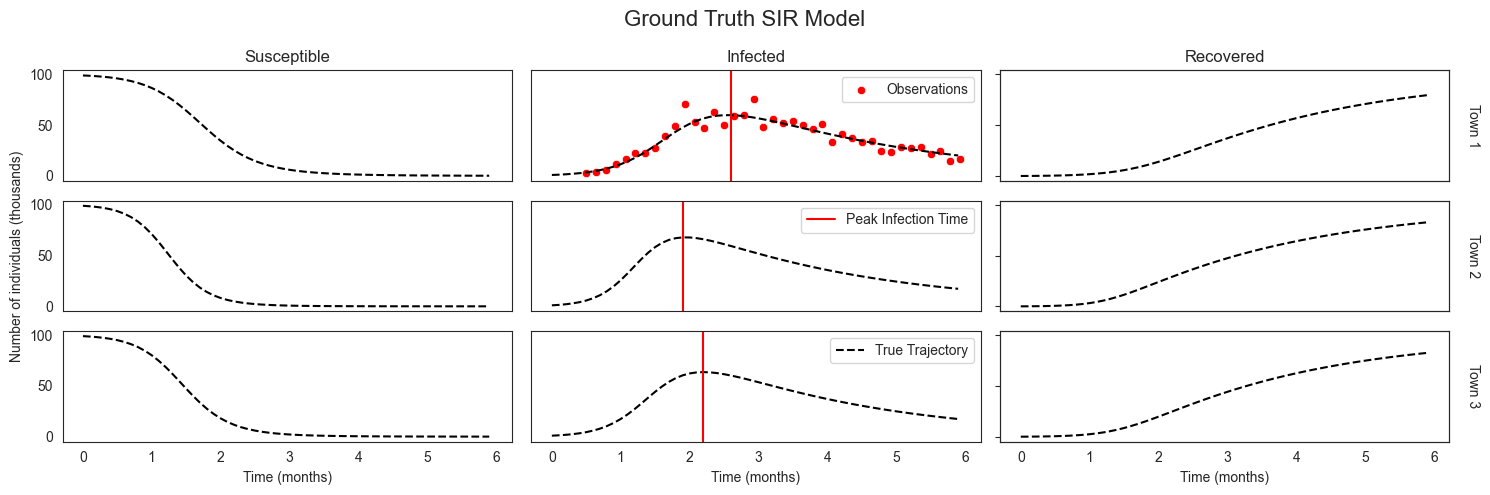

In [48]:
plot_sir_data(
    n_strata,
    colors=colors,
    true_traj=sir_true_traj,
    true_logging_times=logging_times,
    sir_data=sir_data,
    obs_logging_times=obs_logging_times,
    plot_true_peak=True,
    main_title="Ground Truth SIR Model",
)

## <a id='toc1_4_'></a>[Multi-level Bayesian model](#toc0_)

Now we introduce a multi-level structure of uncertainty about the parameters. For local parameters we'll be using  Gamma distributions, which - for convenience - we reparametrize in terms of mean and standard deviation. These will be sampled around group-level coefficiens, the uncertainty about which will be expressed in terms of Beta distributions. We first plot the prior distribution for the higher-level coefficients, $\beta$ and $\gamma$. Then, we use `MultiWorldCounterfactual()` to inspect conditional prior distributions of the local parameters in two different regimes: (1) $\beta = .5, \gamma = .75$, (2) $\beta = 0.05, $\gamma = 0.4$ as examples. This is a somewhat unusual use of the interventional toolkit - with this model structure intervening gives the same result as conditioning, and the way interventions propagate through possible worlds in ChiRho allows us to obtain samples from both settings in a single run without conditioning and perfroming inference. At this point, the reader should notice that the town-level priors (a) shift with the value of the high level coefficients, and that (b) their (conditional) prior distributions are the same. 

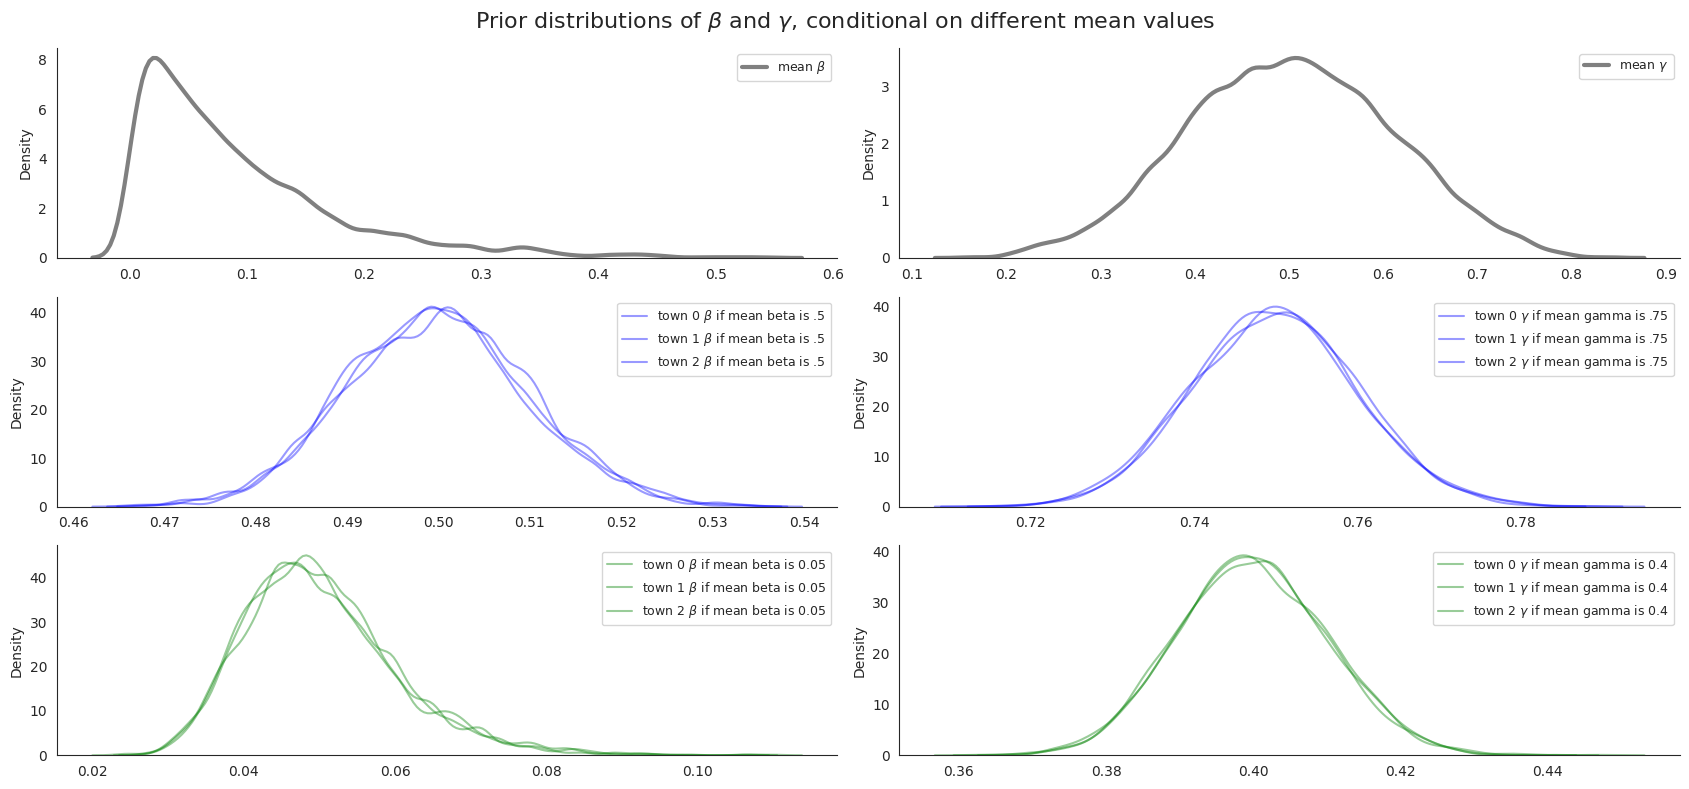

In [7]:
def reparameterize_inverse_gamma(mean, std):
    alpha = 2 + mean**2 / std**2
    beta = mean * (alpha - 1)
    return alpha, beta


def bayesian_multilevel_sir_prior(
    n_strata: int,
) -> tuple[torch.Tensor, torch.Tensor, pyro.plate]:
    beta_mean = pyro.sample("beta_mean", dist.Beta(1, 10))
    beta_std = 0.01

    gamma_mean = pyro.sample("gamma_mean", dist.Beta(10, 10))
    gamma_std = 0.01

    strata_plate = pyro.plate("strata", size=n_strata, dim=-1)

    with strata_plate:
        beta = pyro.sample(
            "beta",
            dist.InverseGamma(*reparameterize_inverse_gamma(beta_mean, beta_std)),
        )
        gamma = pyro.sample(
            "gamma",
            dist.InverseGamma(*reparameterize_inverse_gamma(gamma_mean, gamma_std)),
        )
    return beta, gamma, strata_plate


# let's illustrate prior distributions: they should be similar but not identical
with MultiWorldCounterfactual() as mwc:
    with pyro.poutine.trace() as tr:
        with pyro.plate("samples", num_samples * 5, dim=-2):
            with do(actions={"beta_mean": (torch.tensor(0.5), torch.tensor(0.05)),
                             "gamma_mean": (torch.tensor(0.75), torch.tensor(0.4))}):
                bayesian_multilevel_sir_prior(n_strata)


betas = tr.trace.nodes["beta"]["value"]
gammas = tr.trace.nodes["gamma"]["value"]

beta_mean = tr.trace.nodes["beta_mean"]["value"].squeeze().numpy()
gamma_mean = tr.trace.nodes["gamma_mean"]["value"].squeeze()

with mwc:
    betas_intervention1 = gather(betas, IndexSet(beta_mean={1}, gamma_mean = {1}), event_dim=0).squeeze()
    betas_intervention2 = gather(betas, IndexSet(beta_mean={2}, gamma_mean = {2}), event_dim=0).squeeze()
    
    gammas_intervention1 = gather(gammas, IndexSet(beta_mean={1}, gamma_mean = {1}), event_dim=0).squeeze()
    gammas_intervention2 = gather(gammas, IndexSet(beta_mean={2}, gamma_mean = {2}), event_dim=0).squeeze()


fig, ax = plt.subplots(3, 2, figsize=(17, 8))

sns.kdeplot(
        beta_mean,
        ax=ax[0,0],
        color="gray",
        label="mean $\\beta$",
        linewidth=3,
        bw_adjust=.6,
    )

sns.kdeplot(
        gamma_mean,
        ax=ax[0,1],
        color="gray",
        label="mean $\\gamma$",
        linewidth=3,
        bw_adjust=.6,
    )


for loc, beta in enumerate(betas_intervention1.T):
    sns.kdeplot(
        beta,
        ax=ax[1,0],
        alpha=0.4,
        color="blue",
        label=f"town {loc} $\\beta$ if mean beta is .5",
        linewidth=1.5,
        bw_adjust=.6,
    )

for loc, beta in enumerate(betas_intervention2.T):
    sns.kdeplot(
        beta,
        ax=ax[2,0],
        alpha=0.4,
        color="green",
        label=f"town {loc} $\\beta$ if mean beta is 0.05",
        linewidth=1.5,
        bw_adjust=.6,
    )

for loc, gamma in enumerate(gammas_intervention1.T):
    sns.kdeplot(
        gamma,
        ax=ax[1,1],
        alpha=0.4,
        color="blue",
        label=f"town {loc} $\\gamma$ if mean gamma is .75",
    )

for loc, gamma in enumerate(gammas_intervention2.T):
    sns.kdeplot(
        gamma,
        ax=ax[2,1],
        alpha=0.4,
        color="green",
        label=f"town {loc} $\\gamma$ if mean gamma is 0.4",
    )

size = 9
ax[0,0].legend(prop={'size': size})
ax[0,1].legend(prop={'size': size})
ax[1,0].legend(prop={'size': size})
ax[2,0].legend(prop={'size': size})
ax[1,1].legend(prop={'size': size})
ax[2,1].legend(prop={'size': size})
sns.despine()
plt.suptitle("Prior distributions of $\\beta$ and $\\gamma$, conditional on different mean values", fontsize=16)
plt.tight_layout()
plt.show()




Now we put some components together. First we sample the parameters, then we pass them on to `TorchDiffEq` to simulate.

In [8]:
def simulated_multilevel_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics, is_traced=True
) -> State[torch.Tensor]:
    n_strata = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_strata
    beta, gamma, _ = bayesian_multilevel_sir_prior(n_strata)
    sir = base_model(beta, gamma)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=is_traced) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

This results in a model with the following structure:

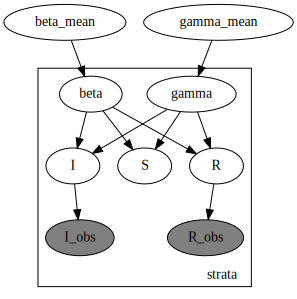

In [10]:
# Note: this is a bit of a hack to render the model.
# For some unknown reason `simulate` does not compose with the model rendering.

def rendering_model(n_strata) -> State[torch.Tensor]:

    beta, gamma, strata_plate = bayesian_multilevel_sir_prior(n_strata)
    sir = SIRDynamics(beta, gamma)
    state = dict(
        S=torch.ones(n_strata) * 99, I=torch.ones(n_strata), R=torch.zeros(n_strata)
    )

    deriv = sir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    deriv = sir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    with strata_plate:
        state = {k: pyro.sample(k, dist.Delta(v)) for k, v in state.items()}

        with pyro.condition(
            data={"I_obs": torch.ones(n_strata), "R_obs": torch.zeros(n_strata)}
        ):
            sir_observation_model(state)


# Note: this only works with Pyro 1.9.0. This will need to wait until ChiRho is updated to Pyro 1.9.0.
# Or force-install that version of Pyro after installing ChiRho, risking some incompatibilities.
pyro.render_model(rendering_model, model_args=(3,), render_deterministic=True)

We can also inspect prior predictions, by generating the samples. Note how the shape of the sample, with some padding, captures the number of samples, the numer of locations, and the number of logging times, respectively. We just add the prior credible intervals to the illustration we've already seen.

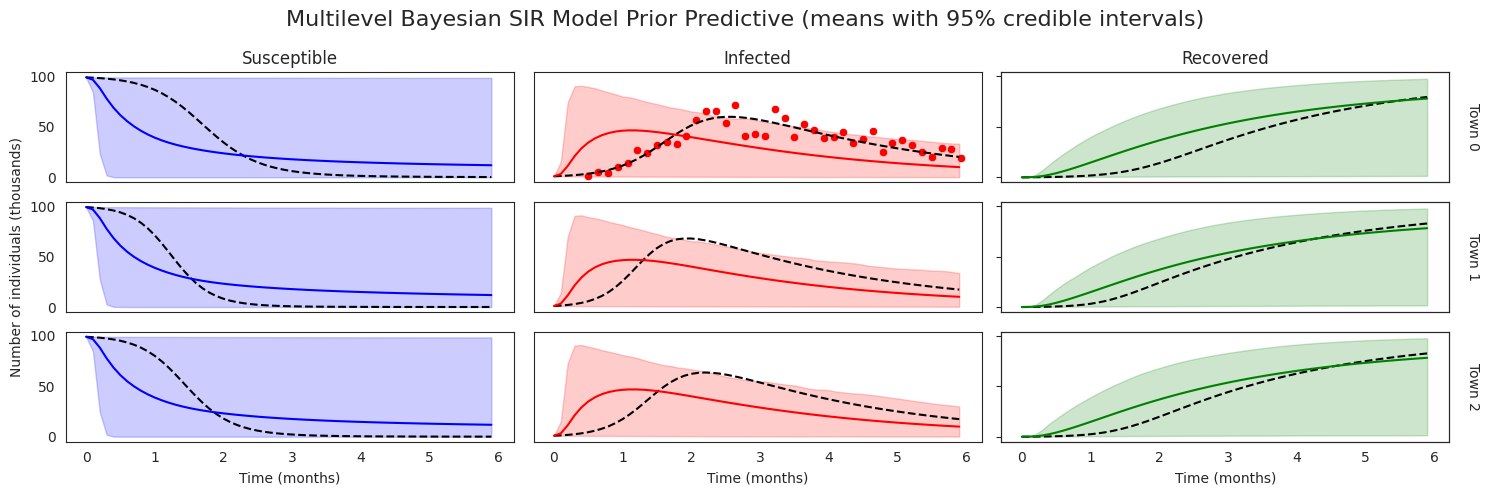

In [11]:
prior_predictive = Predictive(
    simulated_multilevel_bayesian_sir, num_samples=num_samples, parallel=True
)
prior_samples = prior_predictive(init_state, start_time, logging_times)

plot_sir_data(
    n_strata=n_strata,
    colors=colors,
    true_traj=sir_true_traj,
    true_logging_times=logging_times,
    sir_traj=prior_samples,
    logging_times=logging_times,
    sir_data=sir_data,
    obs_logging_times=obs_logging_times,
    main_title="Multilevel Bayesian SIR Model Prior Predictive (means with 95% credible intervals)",
)

We can see that without any data our prior has induced extremely broad uncertainty over resulting disease dynamics.

## <a id='toc1_5_'></a>[Using the model](#toc0_)

### <a id='toc1_5_1_'></a>[Probabilistic Inference over Dynamical System Parameters](#toc0_)

One of the major benefits of writing our dynamical systems model in Pyro and ChiRho is that we can leverage Pyro's support for (partially) automated probabilistic inference. In this section we'll (i) condition on observational data using the `StaticBatchObservation` effect handler and (ii) optimize a variational approximation to the posterior using Pyro's SVI utilities.

In [ ]:
def conditioned_sir(
    obs_times, data, init_state, start_time, base_model=SIRDynamics
) -> None:
    n_strata = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_strata

    beta, gamma, _ = bayesian_multilevel_sir_prior(n_strata)
    sir = base_model(beta, gamma)

    obs = condition(data=data)(single_observation_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])


# Define a helper function to run SVI.
# (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(
    model,
    num_steps=num_steps,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs
):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 25 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [ ]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
)

[iteration 0001] loss: 405.4179
[iteration 0025] loss: 390.6093
[iteration 0050] loss: 253.7541
[iteration 0075] loss: 256.2095
[iteration 0100] loss: 253.6888
[iteration 0125] loss: 249.8266
[iteration 0150] loss: 251.0264
[iteration 0175] loss: 258.7931
[iteration 0200] loss: 248.2431


### <a id='toc1_5_2_'></a>[Inspecting the posterior marginals](#toc0_)

When we inspect the posterior mariginals, we see that our certainty decreased the most for Town 0. However, we also see that our estimates changed for other distributions as well.

In [14]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(
    simulated_multilevel_bayesian_sir,
    guide=sir_guide,
    num_samples=num_samples,
    parallel=True,
)
sir_posterior_samples = sir_predictive(init_state, start_time, logging_times)

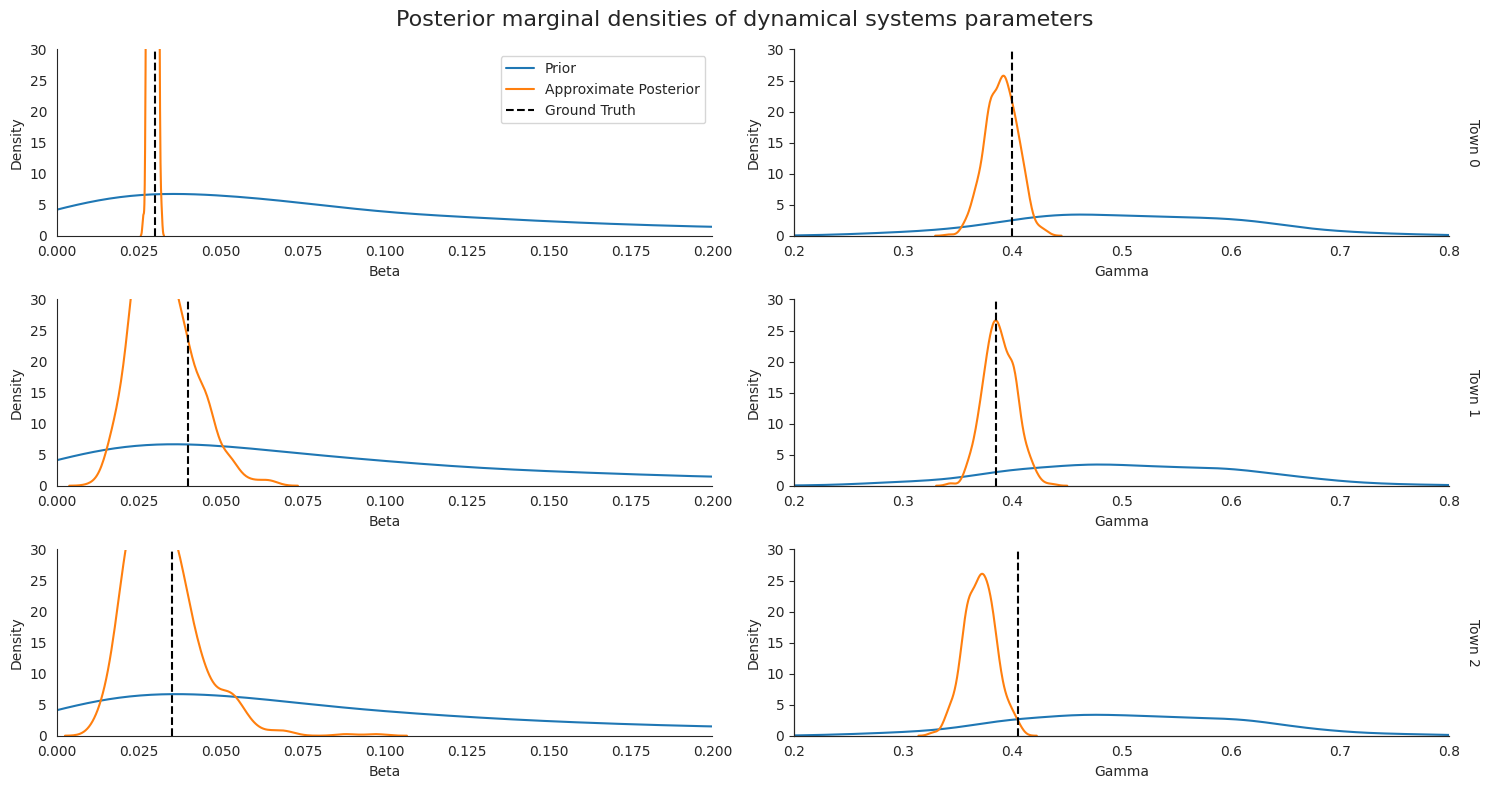

In [ ]:
fig, ax = plt.subplots(n_strata, 2, figsize=(15, 8))

for i in range(n_strata):

    sns.kdeplot(prior_samples["beta"][..., i], label="Prior", ax=ax[i, 0])
    sns.kdeplot(sir_posterior_samples["beta"][..., i], label="Approximate Posterior", ax=ax[i, 0])
    ax[i, 0].axvline(beta_true[i], color="black", label="Ground Truth", linestyle="--")

#    ax[i, 0].set_yticks([])
    ax[i, 0].set_xlabel("Beta")
    ax[i, 0].set_xlim(0, 0.2)
    ax[i, 0].set_ylim(0, 30)

    ax[i, 0].set_ylabel("Density")

    sns.kdeplot(prior_samples["gamma"][..., i], ax=ax[i, 1])
    sns.kdeplot(sir_posterior_samples["gamma"][..., i], ax=ax[i, 1])
    ax[i, 1].axvline(gamma_true[i], color="black", linestyle="--")

    ax[i, 1].set_ylabel("Density")

#    ax[i, 1].set_yticks([])
    ax[i, 1].set_xlabel("Gamma")
    ax[i, 1].set_xlim(0.2, 0.8)
    ax[i, 1].set_ylim(0, 30)

    ax_right_1 = ax[i, 1].twinx()
    ax_right_1.set_ylabel(f"Town {i+1}", rotation=270, labelpad=15)
    ax_right_1.yaxis.set_label_position("right")
    ax_right_1.tick_params(right=False)
    ax_right_1.set_yticklabels([])


ax[0, 0].legend(loc="upper right")

fig.suptitle("Posterior marginal densities of dynamical systems parameters", fontsize=16)
plt.tight_layout()
sns.despine()
plt.show()

# The y limit is cut for readability as absolute values of densities tend to be large.

### <a id='toc1_5_3_'></a>[Inspecting the posterior predictive distribution](#toc0_)

Now that we've approximated the posterior distribution over parameters, let's see how the posterior samples compare to the ground truth parameters and disease trajectories. Notice also the uneven uncertainty decrease across towns.

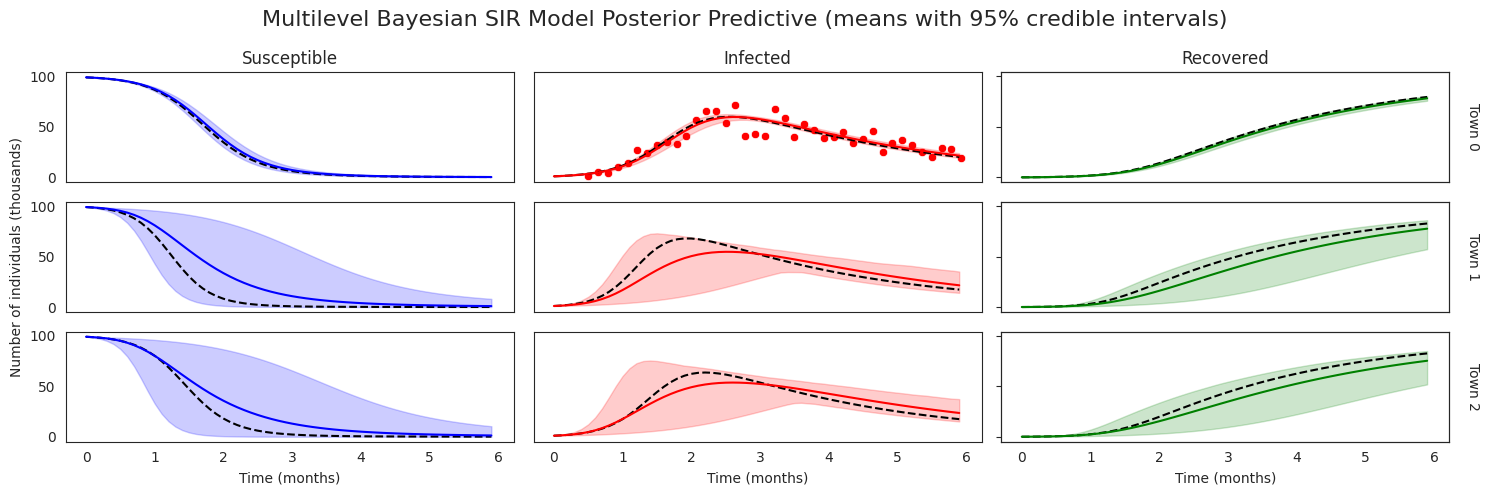

In [ ]:
plot_sir_data(
    n_strata=n_strata,
    colors=colors,
    true_traj=sir_true_traj,
    true_logging_times=logging_times,
    sir_traj=sir_posterior_samples,
    logging_times=logging_times,
    sir_data=sir_data,
    obs_logging_times=obs_logging_times,
    main_title="Multilevel Bayesian SIR Model Posterior Predictive (means with 95% credible intervals)",
)

### <a id='toc1_5_4_'></a>[Modeling Interventions](#toc0_)

Now, as in the [previous tutorial on dynamical systems](https://basisresearch.github.io/chirho/dynamical_intro.html), suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. Following [2]. The strength of lockdown measure at time $t$ by $l(t) \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

$$
\beta(t) = (1 - l(t)) \beta_0,
$$

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l(t)$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

$$
\begin{split}
    dS/dt &= -\beta(t) S I \\
    dI/dt &= \beta(t) S I - \gamma I \\
    dR/dt &= \gamma I
\end{split}
$$

where $S, I, R$ denote the number of susceptible, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$. In our running example, 
we will assume that initially no intervention is being implemented, and consider intervening at time 1.0 with a lockdown policy of strength 0.7. We can implement this new model as follows:

In [17]:
class SIRDynamicsLockdown(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (
            1 - X["l"]
        ) * self.beta0  # time-varing beta parametrized by lockdown strength l_t
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(
            X["l"]
        )  # no dynamics for the lockdown strength unless intervened
        return dX


init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

In [18]:
def intervened_sir(
    lockdown_start, lockdown_strength, init_state, start_time, logging_times
) -> State[torch.Tensor]:
    n_strata = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_strata
    beta, gamma, _ = bayesian_multilevel_sir_prior(n_strata)
    sir = SIRDynamicsLockdown(beta, gamma)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with StaticIntervention(
                time=lockdown_start, intervention=dict(l=lockdown_strength)
            ):
                simulate(sir, init_state, start_time, logging_times[-1])

    return lt.trajectory

In [19]:
lockdown_start = torch.tensor(1.0)
lockdown_strength = torch.tensor([0.7])

true_intervened_sir = pyro.condition(
    intervened_sir, data={"beta": beta_true, "gamma": gamma_true}
)
true_intervened_trajectory = true_intervened_sir(
    lockdown_start, lockdown_strength, init_state_lockdown, start_time, logging_times
)

intervened_sir_posterior_predictive = Predictive(
    intervened_sir, guide=sir_guide, num_samples=num_samples, parallel=True
)
intervened_sir_posterior_samples = intervened_sir_posterior_predictive(
    lockdown_start, lockdown_strength, init_state_lockdown, start_time, logging_times
)

intervened_sir_prior_predictive = Predictive(
    intervened_sir, num_samples=num_samples, parallel=True
)
intervened_sir_prior_samples = intervened_sir_prior_predictive(
    lockdown_start, lockdown_strength, init_state_lockdown, start_time, logging_times
)

First, we visualize the true intervened trajectory and what the **priors*** would predict the effects of an intervention would be. Expectedly, while the predictions are not widely off, the uncertainty is large and they are not very useful.

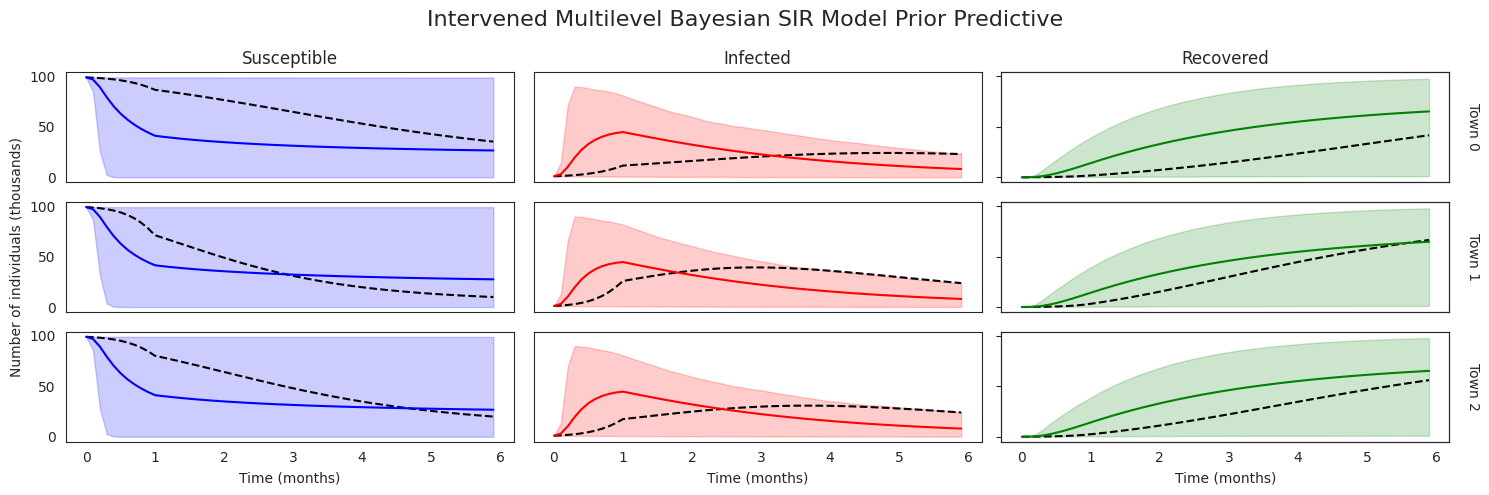

In [20]:
plot_sir_data(
    n_strata,
    colors=colors,
    true_traj=true_intervened_trajectory,
    true_logging_times=logging_times,
    sir_traj=intervened_sir_prior_samples,
    logging_times=logging_times,
    main_title="Intervened Multilevel Bayesian SIR Model Prior Predictive",
)

Now let us use the trained model for the same purpose: as we see, the model is quite sucessful and getting closer to the ground truth, more so at the location at which the observations have been made.

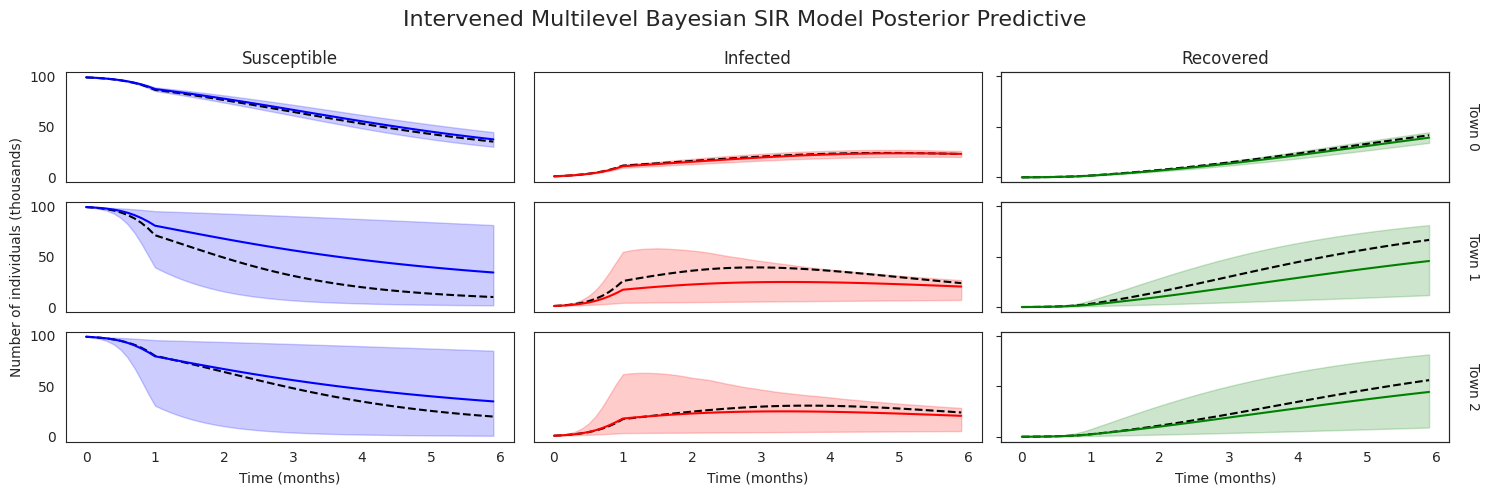

In [ ]:
plot_sir_data(
    n_strata,
    colors=colors,
    true_traj=true_intervened_trajectory,
    true_logging_times=logging_times,
    sir_traj=intervened_sir_posterior_samples,
    logging_times=logging_times,
    main_title="Intervened Multilevel Bayesian SIR Model Posterior Predictive",
)


## <a id='toc1_6_'></a>[Looking Forward](#toc0_)
 
This tutorial is just one of many different ways ChiRho makes it easy to combine statistical techniques with mechanistic models. As non-exhaustive examples, one could instead assume that the mutual information between stratum-level parameters depends on geographic proximity, and/or extend the probabilistic program to regress stratum-level parameters on observed covariates. Our hope is that this and other examples inspire users to be creative, and to explore the rich spectrum between statistical and mechanistic modeling for scientific and policy applications.

## References

Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (1995). *Bayesian data analysis*.